#####

<center> <h1 style='font-size:50px; text-align:center; font-weight:900'>Melanoma vs Normal Moles</h1> </center>

###

![melanoma](https://miiskin.com/wp-content/uploads/2019/09/how-melanoma-looks-like.jpg)

######

# Introduction

* Biomedical image processing has experienced dramatic growth and is an interdisciplinary research field attracting expertise from applied mathematics, computer science, engineering, statistics, physics, biology, and medicine.
* Computer-aided diagnostic processing has already become an important part of the clinical routine.
* Along with the onslaught of new high-tech developments and the use of different imaging modalities, additional challenges arise; for example, how to process and analyze large amounts of images to obtain high-quality information for disease diagnosis and treatment.
* The main objective of this project is to provide an efficient way to diagonize between the melanoma moles and the normal moles.
* This model is build on the VGG 16 architecture which contains sixteen layers which extracts the useful features from the image and thereby processes it.

# Objective

* To train CNN model which is capable of diagnosing melanoma vs non-melanoma cells.
* To improve the accuracy by using transfer learning technique.

# Reason for the project

**Melanoma is a type of skin cancer that can be life-threatening if left untreated. It is essential to diagnose melanoma early to increase the chances of successful treatment and a positive outcome. Melanoma diagnosis is necessary because:**

* **Early Detection:** Early detection of melanoma increases the chances of successful treatment. If diagnosed early, melanoma can often be removed through surgery or other treatments with a high success rate.

* **Prognosis:** The stage of melanoma at the time of diagnosis is a significant factor in determining the prognosis or the likely course of the disease. The earlier the diagnosis, the more favorable the prognosis.

* **Treatment Planning:** The diagnosis of melanoma helps medical professionals to determine the appropriate treatment plan for the patient. Treatment options may include surgery, radiation therapy, chemotherapy, immunotherapy, or a combination of these.

* **Monitoring:** Even after successful treatment, patients with melanoma require ongoing monitoring to detect any recurrence or spread of the disease. Regular check-ups and monitoring are necessary to ensure that the patient remains cancer-free and to detect any signs of a recurrence or spread of the disease.

In summary, the timely diagnosis of melanoma is crucial for the successful treatment and management of the disease. It is important to be aware of any changes in the skin, such as the appearance of new moles or changes in the size, shape, or color of existing moles, and to seek medical attention promptly if any concerns arise.

### Importing the required libraries

In [1]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import cv2 as cv
import random
import os

### Enabling GPU for higher performance

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Initializing the common variables and functions

In [3]:
# Used to resize the image to 224 x 224 size (resolution)

def resize_image(path, save_path):

    for root, dirs, files in os.walk(path):

        for name in dirs:
            
            direct = os.path.join(path, name)
            
            for filename in os.listdir(direct):
                
                img = Image.open(os.path.join(path + "/" + name, filename))
                img = img.resize((224,224))
                
                # images.append(img)
                # filenames.append(name + '/' + filename)
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                if not os.path.exists(save_path + name):
                    os.makedirs(save_path + name)
                img.save(save_path + name + '/' + filename)

In [4]:
# Invoking the function

resize_image(path=train_path, save_path='./processed image/' )

In [5]:
# Defining the common variables

Image_Width=224
Image_Height=224
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
batch_size = 32

In [6]:
# Function to read the image from the given path and append the image, labels, filenames to the given array

def read_image(path, images, labels, filenames):
    
    for root, dirs, files in os.walk(path):

        for name in dirs:
            
            direct = os.path.join(path, name)
            
            for filename in os.listdir(direct):
                
                img = cv.imread(os.path.join(path + "/" + name, filename))
                labels.append(name)
                img = cv.resize(img, Image_Size)
                images.append(img)
                filenames.append(name + '/' + filename)

In [7]:
# Function to create dataframe from the filenames and labels

def create_dataframe(filenames, labels):
    
    df = pd.DataFrame({
        
    'filename' : filenames,
    'category' : labels

    })
    
    return df

In [8]:
# Function to draw countplot for the dataframe category (class: Melanoma, class: Not Melanoma)

def draw_countplot(dataframe, y_axis, title):
    
    sns.countplot(data=dataframe, y = y_axis, width=0.3, palette = 'Set2')
    plt.title(title, weight='black')
    plt.show()

In [9]:
# Initializing train variables

train_filenames = []
train_images = []
train_labels = []
train_path = './processed image/'

# Invoking read_image() in order to read the images from the path and to store in the above initialized array

read_image(path=train_path, images=train_images, labels=train_labels, filenames=train_filenames)

### Train Data

In [10]:
# Train dataframe made from create_dataframe()

train_df = create_dataframe(filenames=train_filenames, labels=train_labels)
train_df

,filename,category
0,Melanoma/AUGmented_0_1000.jpeg,Melanoma
1,Melanoma/AUGmented_0_1007.jpeg,Melanoma
2,Melanoma/AUGmented_0_1009.jpeg,Melanoma
3,Melanoma/AUGmented_0_1022.jpeg,Melanoma
4,Melanoma/AUGmented_0_1029.jpeg,Melanoma
...,...,...
10677,NotMelanoma/ISIC_0034314.jpg,NotMelanoma
10678,NotMelanoma/ISIC_0034315.jpg,NotMelanoma
10679,NotMelanoma/ISIC_0034318.jpg,NotMelanoma
10680,NotMelanoma/ISIC_0034319.jpg,NotMelanoma


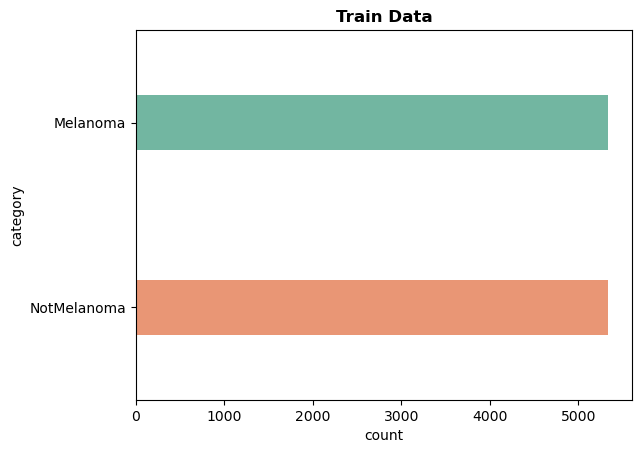

In [11]:
# Invoking draw_countplot()

draw_countplot(dataframe=train_df, y_axis='category', title='Train Data')

In [12]:
# Test dataframe made from create_dataframe()

test_filenames = []
test_images = []
test_labels = []
test_path = './DermMel/test/'

# Invoking read_image() in order to read the images from the path and to store in the above initialized array

read_image(path=test_path, images=test_images, labels=test_labels, filenames=test_filenames)

### Test Data

In [13]:
# Test dataframe made from create_dataframe()

test_df = create_dataframe(filenames=test_filenames, labels=test_labels)
test_df

,filename,category
0,Melanoma/AUGmented_0_1015.jpeg,Melanoma
1,Melanoma/AUGmented_0_1036.jpeg,Melanoma
2,Melanoma/AUGmented_0_1093.jpeg,Melanoma
3,Melanoma/AUGmented_0_1110.jpeg,Melanoma
4,Melanoma/AUGmented_0_1114.jpeg,Melanoma
...,...,...
3556,NotMelanoma/ISIC_0034257.jpg,NotMelanoma
3557,NotMelanoma/ISIC_0034260.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034278.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034309.jpg,NotMelanoma


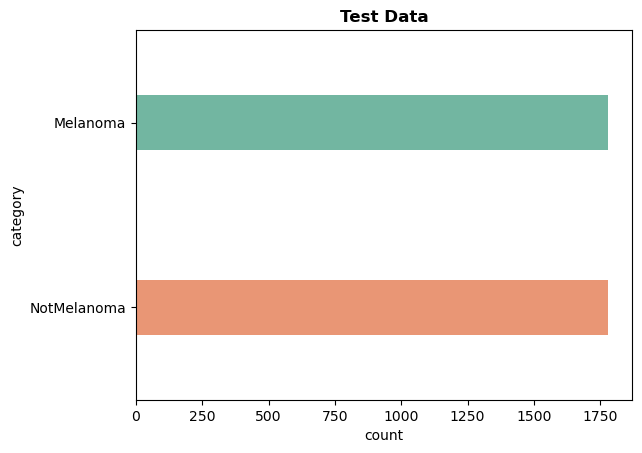

In [14]:
# Invoking draw_countplot()

draw_countplot(dataframe=test_df, y_axis='category', title='Test Data')

### pre-processing and dataset creation

In [15]:
#preprocessing train data

train_datag=ImageDataGenerator(rescale=1./ 255, # converting the pixels of image between o's and 1's
                              horizontal_flip = True, # flipping the image horizontally
                               vertical_flip = True, # flipping the image vertically
                               rotation_range = 25, # rotating the image fro 25 degree
                              )

# Getting train images using flow_from_datafram()

train_dataset=train_datag.flow_from_dataframe(dataframe=train_df, # dataframe name
                                              directory=train_path, # path
                                              x_col="filename", # x_col value
                                              y_col="category", # y_col_value
                                              color_mode='rgb', # color of the image used 'rgb' as the dataset contain rgb image
                                              target_size=Image_Size, # setting the size of the image
                                              batch_size=32, # mini-batch gradient descent (takes 32 images in one go)
                                             )

Found 10682 validated image filenames belonging to 2 classes.


In [16]:
# pre-processing test data

test_datag=ImageDataGenerator(rescale=1./255) # converting the pixels of image between o's and 1's

# Getting test images using flow_from_datafram()

test_dataset=test_datag.flow_from_dataframe(dataframe=test_df, # dataframe name
                                            directory=test_path, # path
                                            x_col="filename", # x_col value
                                            y_col="category", # y_col value
                                            color_mode='rgb', # color of the image used 'rgb' as the dataset contain rgb image
                                            target_size=Image_Size, # setting the size of the image
                                            batch_size=32, # mini-batch gradient descent (takes 32 images in one go)
                                            
                                            # while generating the test_dataset the machine won't validate names, due to some non-acceptable names someof the images are not read by the machine so to avoid that this param is used
                                            validate_filenames=False, # whether to validate names or not 
                                            
                                            shuffle=False, # made shuffle to false in order to make sure that the test dataset isn't shuffled
                                            class_mode='categorical', # categorical is chosen as it is the classification problem
                                           )

Found 3561 non-validated image filenames belonging to 2 classes.


In [17]:
train_dataset.class_indices #gives the key for the target values

{'Melanoma': 0, 'NotMelanoma': 1}

In [18]:
train_dataset[0][0].shape # 32 batches, 128-height, 128-width ,3-d image that is colored image

(32, 224, 224, 3)

### **Model building**

In [19]:
# getting the VGG16 model and making the trainable false,
# so that such a big model wont get trained in our machine, and also this huge model can't be trained in our machine

# This is called transfer learning, this uses the layers of the VGG16 model and the extraction is taken place based on that

conv_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)

# Making the layers to get trained as false

for layer in conv_base.layers:
    layer.trainable = False
    
# Model building
    
model = Sequential()

# Base model (VGG16 Model)
model.add(conv_base)

# flattens the layers (making it into 1-D format)
model.add(Flatten())

# Fully connected layers


# Layer 1
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Layer 2
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Layer 3
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=2, activation='sigmoid'))

# Printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

In [20]:
# defining the optimizer

adam_optimizer = Adam(learning_rate = 0.00003)

# compiling the model

model.compile(loss="CategoricalCrossentropy",optimizer=adam_optimizer, metrics=["accuracy", Precision()])

#### Free up RAM memory to speedup training process

In [21]:
del train_images
del test_images
del train_df
del train_filenames
del test_filenames
del train_labels
del test_labels

### Training

In [22]:
# training the model

with tf.device('/cpu:0'): # enabling cpu to train the model
    history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
334/334 [==============================] - 662s 2s/step - loss: 0.6950 - accuracy: 0.7270 - precision: 0.6941 - val_loss: 0.4147 - val_accuracy: 0.8096 - val_precision: 0.8155
Epoch 2/30
334/334 [==============================] - 665s 2s/step - loss: 0.5711 - accuracy: 0.7710 - precision: 0.7377 - val_loss: 0.3923 - val_accuracy: 0.8239 - val_precision: 0.7909
Epoch 3/30
334/334 [==============================] - 665s 2s/step - loss: 0.5412 - accuracy: 0.7876 - precision: 0.7490 - val_loss: 0.3921 - val_accuracy: 0.8411 - val_precision: 0.8109
Epoch 4/30
334/334 [==============================] - 665s 2s/step - loss: 0.5099 - accuracy: 0.7939 - precision: 0.7534 - val_loss: 0.3796 - val_accuracy: 0.8486 - val_precision: 0.8099
Epoch 5/30
334/334 [==============================] - 670s 2s/step - loss: 0.4973 - accuracy: 0.7980 - precision: 0.7635 - val_loss: 0.3576 - val_accuracy: 0.8475 - val_precision: 0.8099
Epoch 6/30
334/334 [==============================] - 666s 2s/ste

In [55]:
with tf.device('/cpu:0'): # enabling cpu to train the model
    history = model.fit(train_dataset, epochs=50, validation_data=test_dataset,initial_epoch=30)

Epoch 31/50
334/334 [==============================] - 669s 2s/step - loss: 0.3306 - accuracy: 0.8619 - precision: 0.8162 - val_loss: 0.2990 - val_accuracy: 0.8719 - val_precision: 0.8549
Epoch 32/50
334/334 [==============================] - 668s 2s/step - loss: 0.3328 - accuracy: 0.8570 - precision: 0.8086 - val_loss: 0.2875 - val_accuracy: 0.8792 - val_precision: 0.8547
Epoch 33/50
334/334 [==============================] - 671s 2s/step - loss: 0.3193 - accuracy: 0.8614 - precision: 0.8147 - val_loss: 0.2880 - val_accuracy: 0.8778 - val_precision: 0.8403
Epoch 34/50
334/334 [==============================] - 669s 2s/step - loss: 0.3182 - accuracy: 0.8620 - precision: 0.8172 - val_loss: 0.2835 - val_accuracy: 0.8778 - val_precision: 0.8402
Epoch 35/50
334/334 [==============================] - 670s 2s/step - loss: 0.3150 - accuracy: 0.8672 - precision: 0.8221 - val_loss: 0.3019 - val_accuracy: 0.8725 - val_precision: 0.8262
Epoch 36/50
334/334 [==============================] - 672s 

In [56]:
with tf.device('/cpu:0'): # enabling cpu to train the model
    history = model.fit(train_dataset, epochs=60, validation_data=test_dataset,initial_epoch=50)

Epoch 51/60
334/334 [==============================] - 664s 2s/step - loss: 0.2859 - accuracy: 0.8788 - precision: 0.8285 - val_loss: 0.2833 - val_accuracy: 0.8818 - val_precision: 0.8543
Epoch 52/60
334/334 [==============================] - 665s 2s/step - loss: 0.2890 - accuracy: 0.8766 - precision: 0.8295 - val_loss: 0.2656 - val_accuracy: 0.8854 - val_precision: 0.8622
Epoch 53/60
334/334 [==============================] - 667s 2s/step - loss: 0.2870 - accuracy: 0.8806 - precision: 0.8299 - val_loss: 0.2899 - val_accuracy: 0.8821 - val_precision: 0.8652
Epoch 54/60
334/334 [==============================] - 665s 2s/step - loss: 0.2826 - accuracy: 0.8821 - precision: 0.8333 - val_loss: 0.2769 - val_accuracy: 0.8846 - val_precision: 0.8682
Epoch 55/60
334/334 [==============================] - 669s 2s/step - loss: 0.2893 - accuracy: 0.8787 - precision: 0.8309 - val_loss: 0.2709 - val_accuracy: 0.8882 - val_precision: 0.8385
Epoch 56/60
334/334 [==============================] - 667s 

In [57]:
with tf.device('/cpu:0'): # enabling cpu to train the model
    history = model.fit(train_dataset, epochs=100, validation_data=test_dataset,initial_epoch=60)

Epoch 61/100
334/334 [==============================] - 664s 2s/step - loss: 0.2826 - accuracy: 0.8798 - precision: 0.8336 - val_loss: 0.2784 - val_accuracy: 0.8857 - val_precision: 0.8513
Epoch 62/100
334/334 [==============================] - 668s 2s/step - loss: 0.2731 - accuracy: 0.8832 - precision: 0.8360 - val_loss: 0.2661 - val_accuracy: 0.8888 - val_precision: 0.8658
Epoch 63/100
334/334 [==============================] - 668s 2s/step - loss: 0.2761 - accuracy: 0.8807 - precision: 0.8383 - val_loss: 0.2963 - val_accuracy: 0.8748 - val_precision: 0.8473
Epoch 64/100
334/334 [==============================] - 668s 2s/step - loss: 0.2717 - accuracy: 0.8827 - precision: 0.8389 - val_loss: 0.2580 - val_accuracy: 0.8865 - val_precision: 0.8820
Epoch 65/100
334/334 [==============================] - 669s 2s/step - loss: 0.2654 - accuracy: 0.8863 - precision: 0.8483 - val_loss: 0.2949 - val_accuracy: 0.8807 - val_precision: 0.8745
Epoch 66/100
334/334 [==============================] -

In [85]:
with tf.device('/cpu:0'): # enabling cpu to train the model
    history = model.fit(train_dataset, epochs=150, validation_data=test_dataset,initial_epoch=100)

Epoch 101/150
334/334 [==============================] - 680s 2s/step - loss: 0.2307 - accuracy: 0.9021 - precision: 0.8632 - val_loss: 0.3235 - val_accuracy: 0.8694 - val_precision: 0.8348
Epoch 102/150
334/334 [==============================] - 683s 2s/step - loss: 0.2310 - accuracy: 0.9041 - precision: 0.8618 - val_loss: 0.2452 - val_accuracy: 0.8961 - val_precision: 0.8717
Epoch 103/150
334/334 [==============================] - 687s 2s/step - loss: 0.2427 - accuracy: 0.9003 - precision: 0.8590 - val_loss: 0.2431 - val_accuracy: 0.8944 - val_precision: 0.8633
Epoch 104/150
334/334 [==============================] - 683s 2s/step - loss: 0.2425 - accuracy: 0.8998 - precision: 0.8601 - val_loss: 0.2634 - val_accuracy: 0.8910 - val_precision: 0.8558
Epoch 105/150
334/334 [==============================] - 682s 2s/step - loss: 0.2370 - accuracy: 0.9015 - precision: 0.8640 - val_loss: 0.2984 - val_accuracy: 0.8781 - val_precision: 0.8702
Epoch 106/150
334/334 [===========================

In [86]:
# saving the model locally

model.save("melanoma-VGG16base-model-150.h5")
print("Saved model to disk")

Saved model to disk


### Validation

In [87]:
# Initializing validation variables

validation_filenames = []
validation_images = []
validation_labels = []
validation_path = './DermMel/valid/'

# Invoking read_image() in order to read the images from the path and to store in the above initialized array

read_image(path=validation_path, images=validation_images, labels=validation_labels, filenames=validation_filenames)

### Validation Data

In [88]:
# Test dataframe made from create_dataframe()

val_df = create_dataframe(filenames=validation_filenames, labels=validation_labels)
val_df

,filename,category
0,Melanoma/AUGmented_0_1006.jpeg,Melanoma
1,Melanoma/AUGmented_0_1058.jpeg,Melanoma
2,Melanoma/AUGmented_0_110.jpeg,Melanoma
3,Melanoma/AUGmented_0_1108.jpeg,Melanoma
4,Melanoma/AUGmented_0_1140.jpeg,Melanoma
...,...,...
3557,NotMelanoma/ISIC_0034292.jpg,NotMelanoma
3558,NotMelanoma/ISIC_0034297.jpg,NotMelanoma
3559,NotMelanoma/ISIC_0034305.jpg,NotMelanoma
3560,NotMelanoma/ISIC_0034308.jpg,NotMelanoma


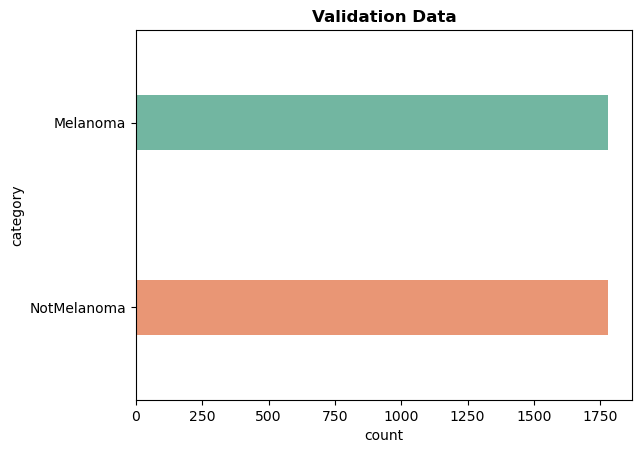

In [89]:
# Invoking draw_count_plot()

draw_countplot(dataframe=val_df, y_axis='category', title='Validation Data')

### pre-processing and validation dataset creation

In [90]:
# pre-processing test data

val_datag=ImageDataGenerator(rescale=1./255) # converting the pixels of image between o's and 1's

# Getting test images using flow_from_datafram()

val_dataset=val_datag.flow_from_dataframe(dataframe=val_df, # dataframe name
                                            directory=validation_path, # path
                                            x_col="filename", # x_col value
                                            y_col="category", # y_col value
                                            color_mode='rgb', # color of the image used 'rgb' as the dataset contain rgb image
                                            target_size=Image_Size, # setting the size of image
                                            batch_size=32,  # mini-batch gradient descent (takes 32 images in one go)
                                            
                                            # while generating the test_dataset the machine won't validate names, due to some non-acceptable names someof the images are not read by the machine so to avoid that this param is used
                                            validate_filenames=False, # whether to validate names or not 
                                          
                                            shuffle=False, # made shuffle to false in order to make sure that the test dataset isn't shuffled
                                            class_mode='categorical', # categorical is chosen as it is the classification problem
                                           )

Found 3562 non-validated image filenames belonging to 2 classes.


In [91]:
test_dataset.class_indices #gives the key for the target values

{'Melanoma': 0, 'NotMelanoma': 1}

In [92]:
val_dataset.class_indices #gives the key for the target values

{'Melanoma': 0, 'NotMelanoma': 1}

### **Predicting**

#### test_df

In [93]:
# predicting the model with test dataset

with tf.device('/cpu:0'):
    test_pred=model.predict(test_dataset)

112/112 [==============================] - 166s 1s/step


In [94]:
# getting the index of the highest value

test_df["predict"]=np.argmax(test_pred,axis=1)

In [95]:
# Assigning the class names for the keys in predict column of the test_df

test_df["predict_c"]=test_df["predict"].map({0:"Melanoma",1:"NotMelanoma"})

In [96]:
# dispaying the dataframe

test_df

,filename,category,predict,predict_c
0,Melanoma/AUGmented_0_1015.jpeg,Melanoma,0,Melanoma
1,Melanoma/AUGmented_0_1036.jpeg,Melanoma,0,Melanoma
2,Melanoma/AUGmented_0_1093.jpeg,Melanoma,0,Melanoma
3,Melanoma/AUGmented_0_1110.jpeg,Melanoma,0,Melanoma
4,Melanoma/AUGmented_0_1114.jpeg,Melanoma,0,Melanoma
...,...,...,...,...
3556,NotMelanoma/ISIC_0034257.jpg,NotMelanoma,0,Melanoma
3557,NotMelanoma/ISIC_0034260.jpg,NotMelanoma,1,NotMelanoma
3558,NotMelanoma/ISIC_0034278.jpg,NotMelanoma,0,Melanoma
3559,NotMelanoma/ISIC_0034309.jpg,NotMelanoma,1,NotMelanoma


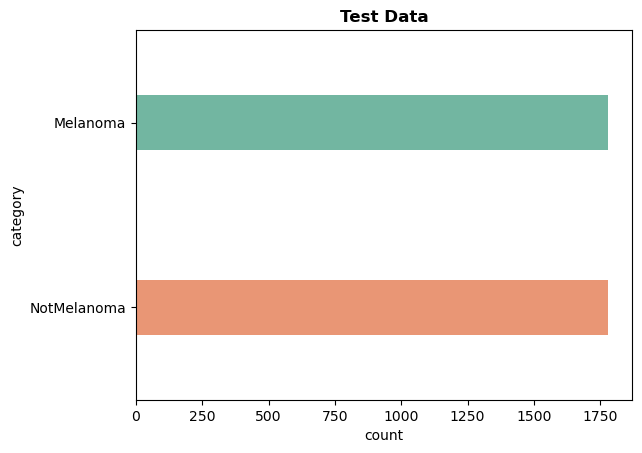

In [97]:
# Invoking draw_countplot()

draw_countplot(dataframe=test_df, y_axis='category', title='Test Data')

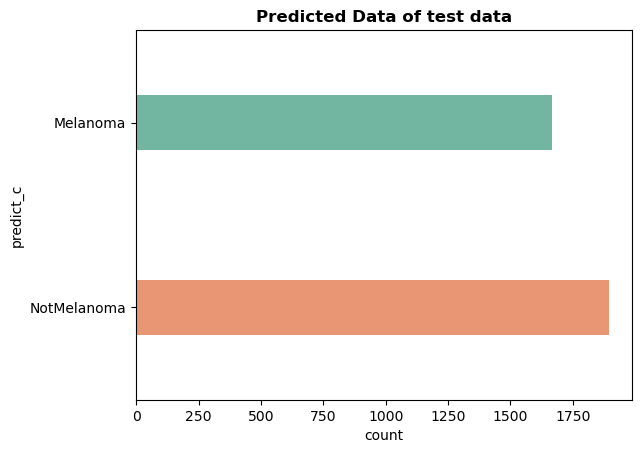

In [98]:
# Invoking draw_countplot()

draw_countplot(dataframe=test_df, y_axis='predict_c', title='Predicted Data of test data')

In [99]:
# Returns the number of data in each category, the predicted count

test_df['predict_c'].value_counts()

NotMelanoma    1893
Melanoma       1668
Name: predict_c, dtype: int64

In [100]:
# Returns the number of data in each category, the actual count

test_df['category'].value_counts()

Melanoma       1781
NotMelanoma    1780
Name: category, dtype: int64

In [101]:
# getting the classification report for the test data

print(classification_report(y_pred=test_df['predict_c'], y_true=test_df['category']))

              precision    recall  f1-score   support

    Melanoma       0.93      0.87      0.90      1781
 NotMelanoma       0.88      0.93      0.90      1780

    accuracy                           0.90      3561
   macro avg       0.90      0.90      0.90      3561
weighted avg       0.90      0.90      0.90      3561



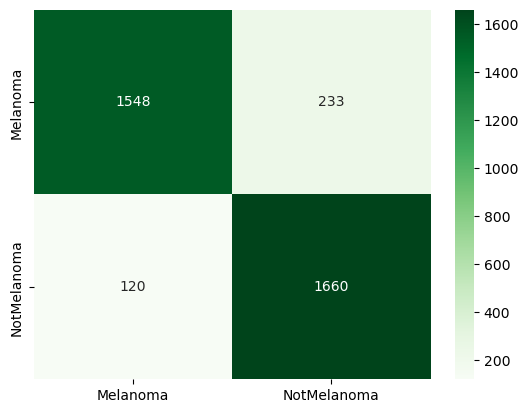

In [102]:
# confusion matrix for test data

sns.heatmap(confusion_matrix(y_pred=test_df['predict_c'], y_true=test_df['category']), annot=True,
            xticklabels=test_df['category'].unique(), yticklabels=test_df['category'].unique(), cmap='Greens', fmt='')
plt.show()

In [103]:
# predicting the model with validation dataset

with tf.device('/cpu:0'):
    val_pred=model.predict(val_dataset)

112/112 [==============================] - 166s 1s/step


In [104]:
# getting the index of the highest value

val_df["predict"]=np.argmax(val_pred,axis=1)

In [105]:
# Assigning the class names for the keys in predict column of the val_df

val_df["predict_c"]=val_df["predict"].map({0:"Melanoma",1:"NotMelanoma"})

In [106]:
# displaying the dataframe

val_df

,filename,category,predict,predict_c
0,Melanoma/AUGmented_0_1006.jpeg,Melanoma,0,Melanoma
1,Melanoma/AUGmented_0_1058.jpeg,Melanoma,0,Melanoma
2,Melanoma/AUGmented_0_110.jpeg,Melanoma,0,Melanoma
3,Melanoma/AUGmented_0_1108.jpeg,Melanoma,0,Melanoma
4,Melanoma/AUGmented_0_1140.jpeg,Melanoma,0,Melanoma
...,...,...,...,...
3557,NotMelanoma/ISIC_0034292.jpg,NotMelanoma,1,NotMelanoma
3558,NotMelanoma/ISIC_0034297.jpg,NotMelanoma,1,NotMelanoma
3559,NotMelanoma/ISIC_0034305.jpg,NotMelanoma,1,NotMelanoma
3560,NotMelanoma/ISIC_0034308.jpg,NotMelanoma,1,NotMelanoma


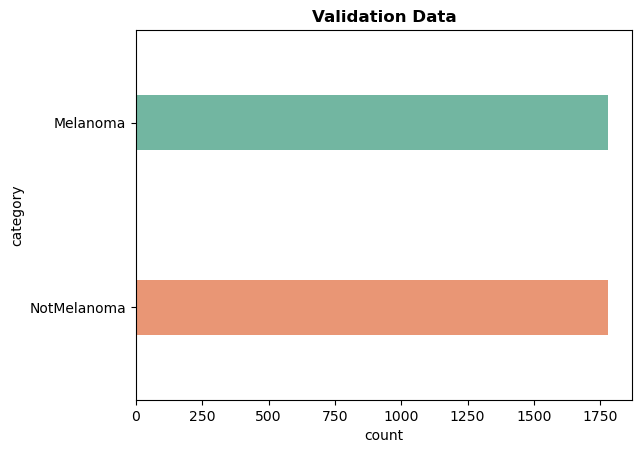

In [107]:
# Invoking draw_countplot()

draw_countplot(dataframe=val_df, y_axis='category', title='Validation Data')

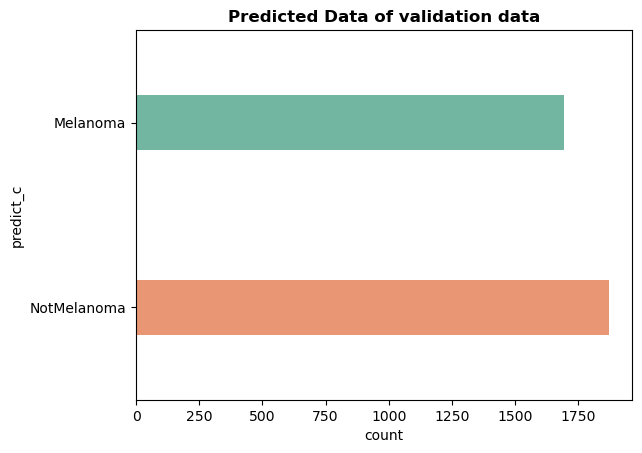

In [108]:
# Invoking draw_countplot()

draw_countplot(dataframe=val_df, y_axis='predict_c', title='Predicted Data of validation data')

In [109]:
# Returns the number of data in each category, the predicted count

val_df['predict_c'].value_counts()

NotMelanoma    1870
Melanoma       1692
Name: predict_c, dtype: int64

In [110]:
# Returns the number of data in each category, the actual count

val_df['category'].value_counts()

Melanoma       1781
NotMelanoma    1781
Name: category, dtype: int64

In [111]:
# getting the classification report for the validation data

print(classification_report(y_pred=val_df['predict_c'], y_true=val_df['category']))

              precision    recall  f1-score   support

    Melanoma       0.93      0.89      0.91      1781
 NotMelanoma       0.89      0.94      0.91      1781

    accuracy                           0.91      3562
   macro avg       0.91      0.91      0.91      3562
weighted avg       0.91      0.91      0.91      3562



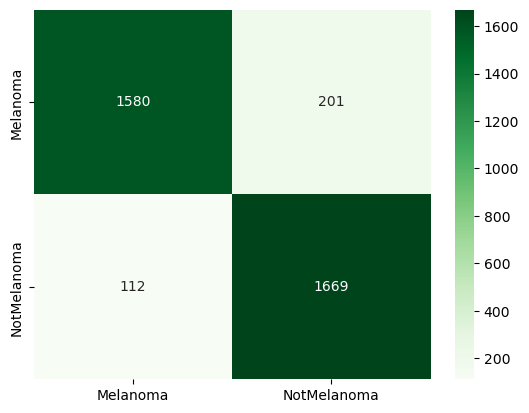

In [112]:
# confusion matrix for validation data

sns.heatmap(confusion_matrix(y_pred=val_df['predict_c'], y_true=val_df['category']), annot=True,
            xticklabels=val_df['category'].unique(), yticklabels=val_df['category'].unique(), cmap='Greens', fmt='')
plt.show()

# Summary
* The model gives **90% accuracy and 87% precision** in the **training data.**
* In the **testing data** the model gives **90% of accuracy and 88+ % precision.**
* In the **validation data** the model gives **91% of accuracy and 89+ % precision.**

### Prediction count on the test dataset

* The dataset contains **1781 melanoma** images and **1780 non melanoma** images.
* Among that it predicted **1548 melanoma** and **1650 non melanoma** were **correctly.**
* the images of count **233 melanoma** and **120 non melanoma** were predicted **wrongly.**


### Prediction count on the validation data dataset

* The dataset contains **1781 melanoma** and **non melanoma** images.
* Among that it predicted **1580 melanoma** and **1669 non melanoma** were **correctly.**
* the images of count **201 melanoma** and **112 non melanoma** were predicted **wrongly.**